In [1]:
from find_optimal_traj import solve_el_bvp
from utils import compute_functional_dist, compute_djs_matrix, compute_mds_embedding
from plotting import plot_settings, plot_trajectories
import matplotlib.pyplot as plt
import seaborn as sns
from network import Network

import torch

Dimension d = 2


/Users/tomernadiv/Desktop/MSc/Projects/OptimalPlasticity/code/plotting.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


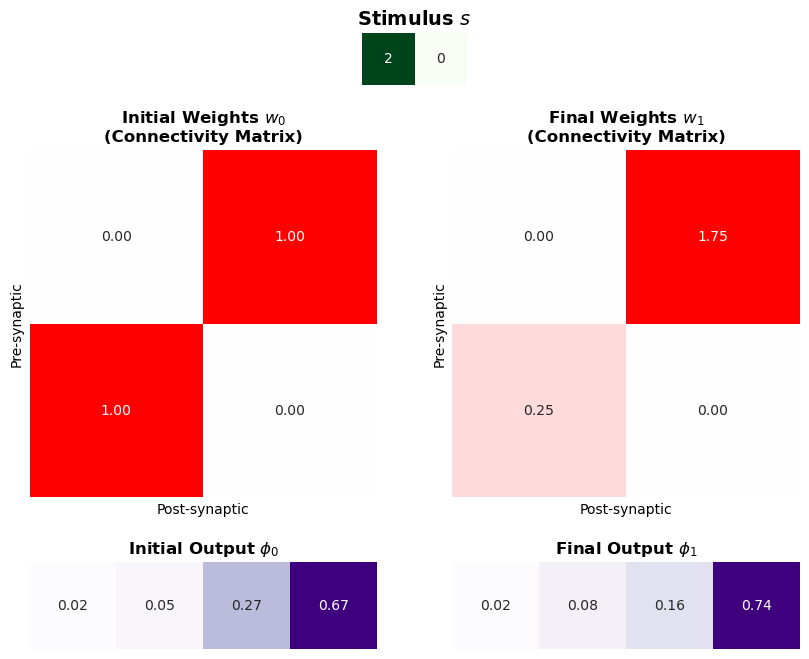

In [2]:
n = 2
d = n**2 - n
print("Dimension d =", d)
device = 'cpu'
w0 = torch.tensor([1., 1.])
w1 = torch.tensor([1.75, 0.25])
s = torch.tensor([2., 0.])
net = Network(n, device)
pi0 = net(w0, s).detach().cpu()    
pi1 = net(w1, s).detach().cpu()

plot_settings(w0, w1, pi0, pi1, s)

In [5]:
n_points = 100
alphas = [1., 0.5, 0.1, 0.01, 0.005]
sols = []
sols_objects = []

# solve bvps
for alpha in alphas:
    sol = solve_el_bvp(w0, w1, net, s, alpha, n_points=n_points)
    w_traj = sol.y[:d, :]
    t = sol.x
    sols.append((t, w_traj, alpha))
    sols_objects.append(sol)
    print(f"Solved BVP for alpha={alpha}, Success: {sol.success}, Message: {sol.message}")


# compute MDS embedding
func_embeddings = []
for (t, w_traj, alpha) in sols:
    pi_traj = compute_functional_dist(net, w_traj, s)
    djs_matrix = compute_djs_matrix(pi_traj)
    embedding = compute_mds_embedding(djs_matrix, n_components=2)
    func_embeddings.append((t, embedding, alpha))

Solved BVP for alpha=1.0, Success: False, Message: A singular Jacobian encountered when solving the collocation system.
Solved BVP for alpha=0.5, Success: True, Message: The algorithm converged to the desired accuracy.
Solved BVP for alpha=0.1, Success: True, Message: The algorithm converged to the desired accuracy.
Solved BVP for alpha=0.01, Success: True, Message: The algorithm converged to the desired accuracy.
Solved BVP for alpha=0.005, Success: True, Message: The algorithm converged to the desired accuracy.


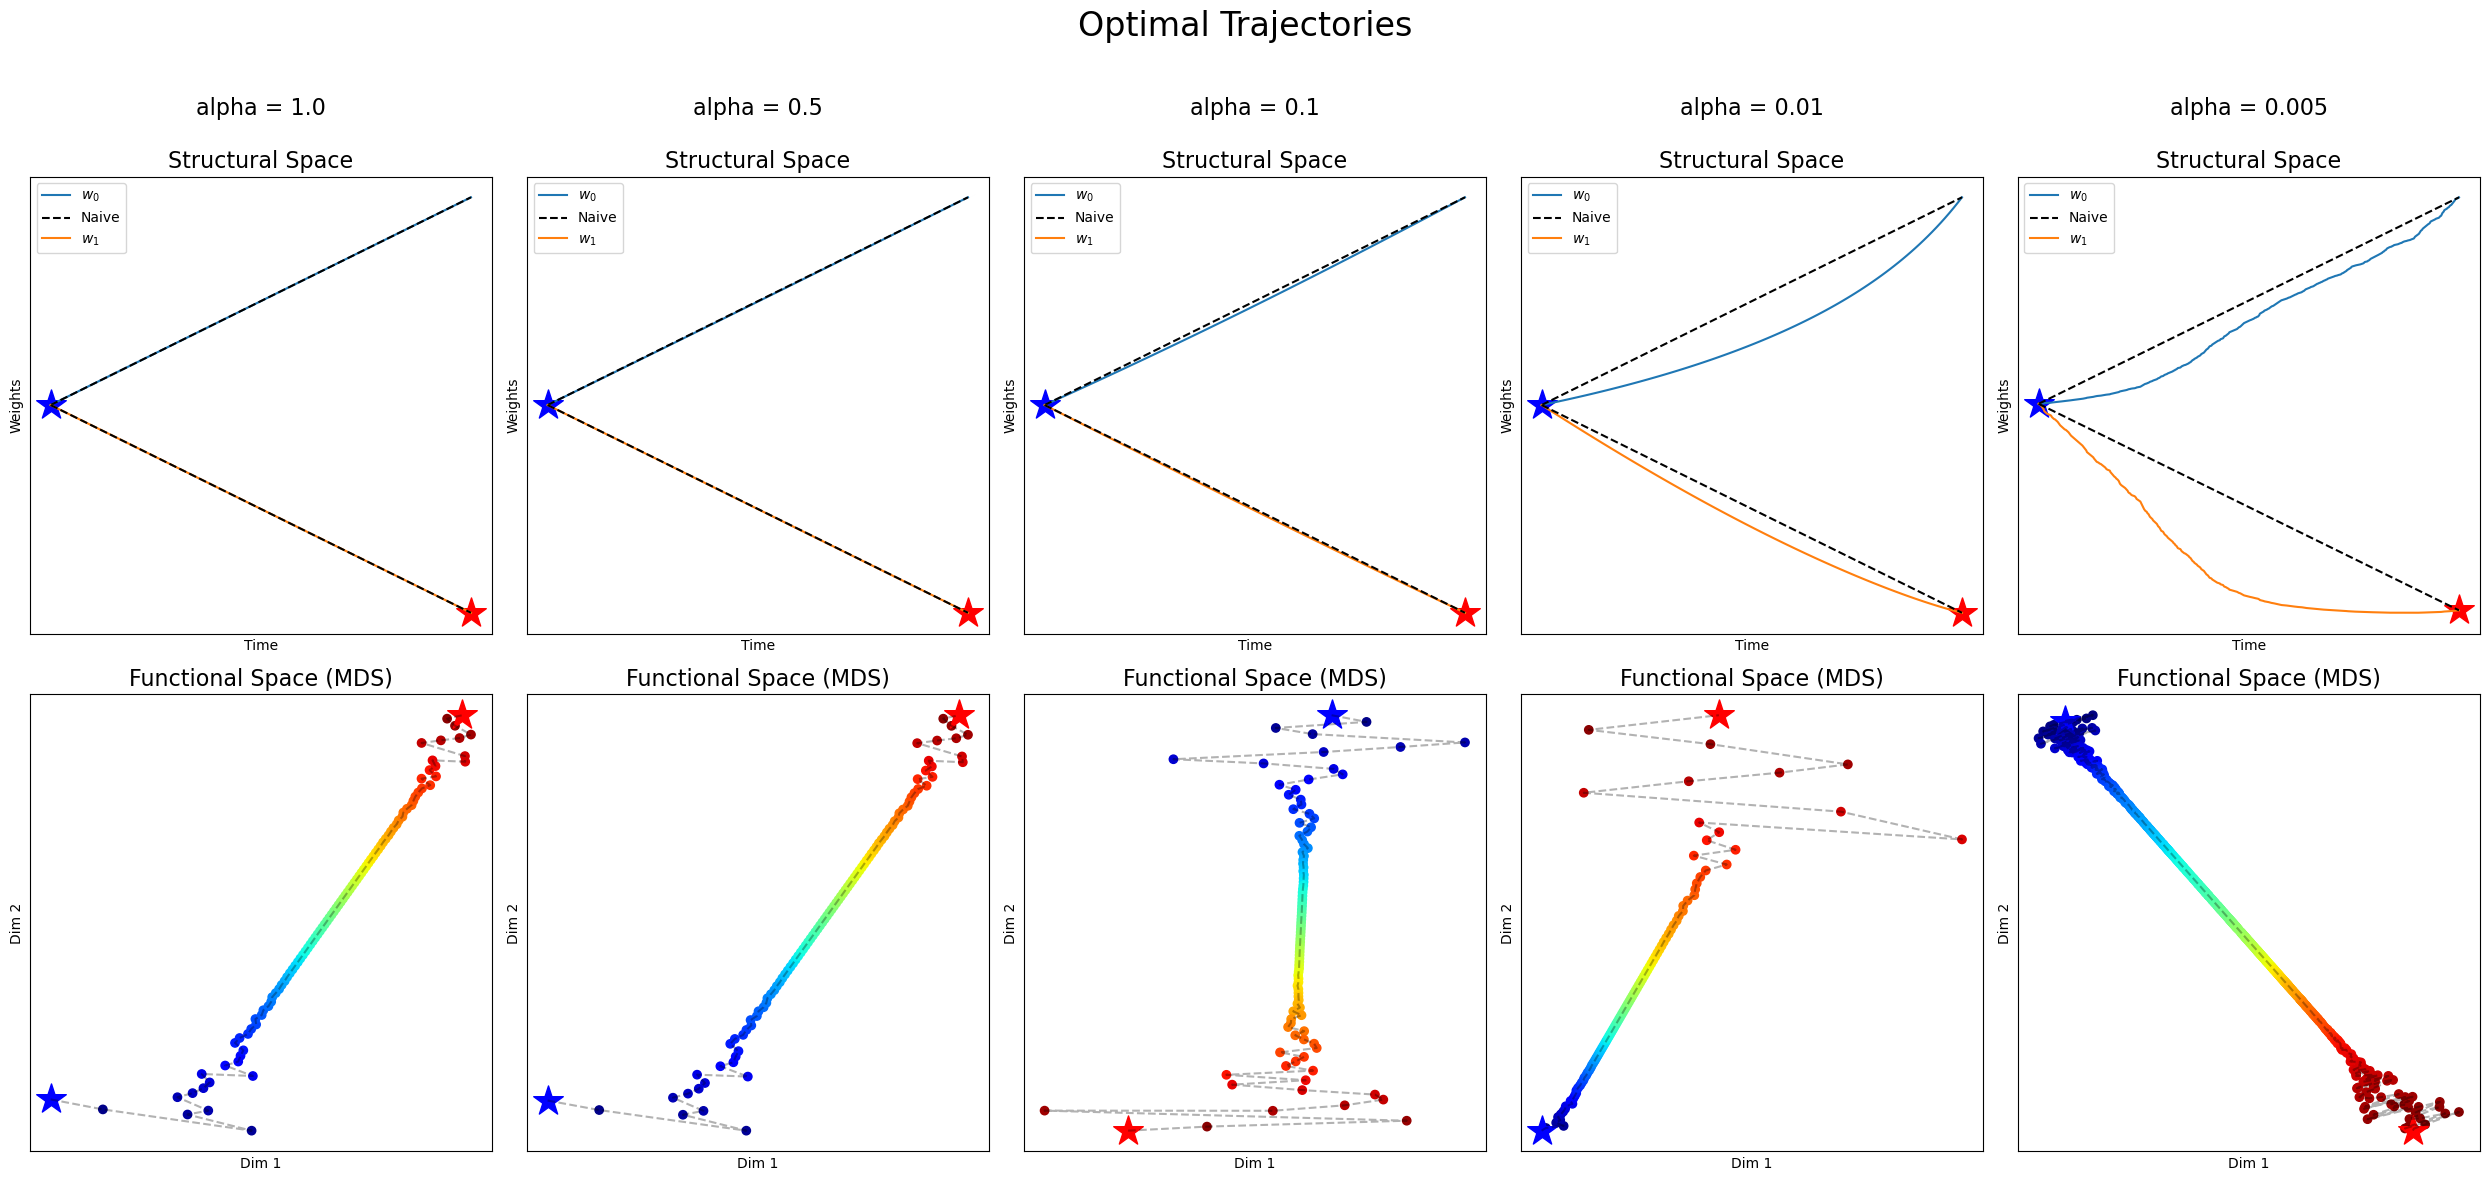

In [6]:
plot_trajectories(sols, func_embeddings, w0, w1)